# Example pipeline

- loading various RGBD datasets
- detecting and unwarping planes
- detecting keypoints
- describing with SIFT and TFeat
- comparing descriptor matches with ground truth matches
- plotting accuracies

In [1]:
get_ipython().magic('run util_notebook.py')
get_ipython().magic('run -i geometry.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
get_ipython().magic('run -i config.py')
get_ipython().magic('run -i datasets.py')
get_ipython().magic('run -i planes.py')

In [3]:
get_ipython().magic('run -i keypoint_projection.py')
get_ipython().magic('run -i patches.py')
get_ipython().magic('run -i detectors.py')
get_ipython().magic('run -i matching.py')

In [4]:
# Discover datasets

# synth
dsets_synth = discover_synthetic_dsets(CFG_BASE)
dsets_synth_train = dsets_synth[:300]
dsets_synth_test = dsets_synth[300:]

# 7sc
dsets_7sc = discover_7scenes(CFG_BASE, 
	scenes_train=['pumpkin', 'office', 'stairs', 'chess'],
	scenes_test=['fire', 'redkitchen', 'heads'],
)

# arch
dsets_arch_test = [
	DatasetSouthBuilding(CFG_BASE),
	DatasetPersonHall(CFG_BASE),
]
dsets_arch_train = [
	DatasetGerrardHall(CFG_BASE),
	DatasetGrahamHall(CFG_BASE),
]


In [5]:
# Load a sequence
dset = dsets_arch_test[0]
data = dset.get_sequence(42, 5, stride=1)

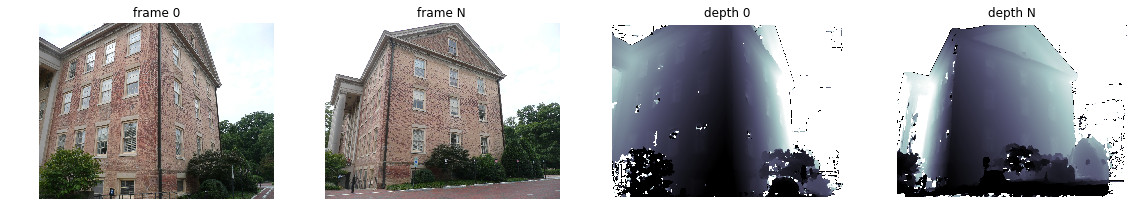

In [6]:
# Show example frames from the loaded sequence
summarize_seq(data, b_save=False)

In [7]:
# Detect planes in the sequence
seq_detect_planes(data, b_normals=True)

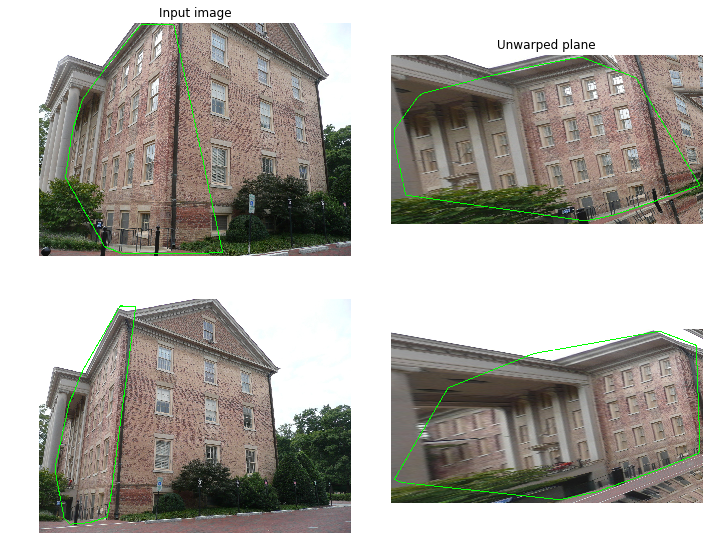

In [8]:
# Show examples of unwarping

show_multidim([
		frame_draw_unwarp_demo(data.frames[2], plane_by_size=1),
		frame_draw_unwarp_demo(data.frames[4], plane_by_size=1),
	],
	figscale=(5, 4),
	col_titles = ['Input image', 'Unwarped plane'],
	save=pp(DIR_OUT_FIGURES, 'unwarp_example_arch.jpg')
)
None


In [9]:
# Make a second copy of the sequence, for the unwarp-before-detection detector
data_ubd = seq_clone(data)

In [ ]:
# Detect keypoints in original images
# cut patches and calculate SIFT descriptors
seq_detect_sift_flat(data, b_progress=True)

# Calculate SIFT descriptors on unwarped planes (unwarp-after-detection)
parallel_process(frame_describe_unwarp, data.frames, disp_progress=True)

In [ ]:
# Detect keypoints in unwarped planes, (unwarp-before-detection)
seq_detect_sift_unwarp(data_ubd)

In [17]:
get_ipython().magic('run -i descriptor_tfeat.py')

In [18]:
# Load NN weights
tfeat_7sc_flat = TFeatRunner(
	name='net_7sc_int', 
	model_file=pp(DIR_OUT_MODELS, '7sc_flat_int', 'weights_020.hdf5'), 
	net_type=PatchMode.INTENSITY,
)

In [19]:
# calculate NN descriptions
parallel_process(
	tfeat_7sc_flat.describe_patch_list,
	get_patch_lists(data.frames, ['flat', 'unwarp']) + get_patch_lists(data_ubd.frames, ['unwarp_det']),
	threading=False,
	disp_progress=True,
)

In [20]:
# List of extracted patch and descriptor types

print('Original + unwarp after detection')
print('- Extracted patch types:\n	', list(data.frames[0].patch_lists.keys()))
# Descriptions organized by (patch type, descriptor type)
print('- Descriptions:\n	', '\n	'.join(map(str, data.frames[0].descriptions.keys())))
print('---')
print('Unwarp before detection')
print('- Extracted patch types:\n	', list(data_ubd.frames[0].patch_lists.keys()))
print('- Descriptions:\n	', '\n	'.join(map(str, data_ubd.frames[0].descriptions.keys())))

Original + unwarp after detection
- Extracted patch types:
	 ['flat', 'unwarp']
- Descriptions:
	 ('flat', 'sift')
	('unwarp', 'sift')
	('flat', 'net_7sc_int')
	('unwarp', 'net_7sc_int')
---
Unwarp before detection
- Extracted patch types:
	 ['unwarp_det']
- Descriptions:
	 ('unwarp_det', 'sift')
	('unwarp_det', 'net_7sc_int')


In [25]:
print('Patches:')
print('- depth array shape', data.frames[0].patch_lists['flat'].depth_array.shape)
print('- normals array shape', data.frames[0].patch_lists['flat'].normals_array.shape)

print('Descriptions:')
dkey = ('flat', 'net_7sc_int')
print('- Descriptor', dkey, data.frames[0].descriptions[dkey].descriptors.shape)

Patches:
- depth array shape (5110, 32, 32)
- normals array shape (5110, 32, 32, 3)
Descriptions:
- Descriptor ('flat', 'net_7sc_int') (5110, 128)


In [26]:
# Comparison of ground-truth matches with descriptor matches

measurements = POOL.map(
	lambda fr: match_frame_pair(data.frames[0], fr),
	data.frames[1:],
)
measurements_ubd = POOL.map(
	lambda fr: match_frame_pair(data_ubd.frames[0], fr),
	data_ubd.frames[1:],
)

acc = AccuracyAccumulator()
for m in measurements + measurements_ubd:
	acc_add_measurements(acc, m)


In [38]:
print('Ground truth matches:', 
	measurements[0]['gt_pairs'][:10, :], '...',
)

print('Redetected using descriptors:', 
	measurements[0]['descr_redetects'][('flat', 'sift')][:10], '...',
)

Ground truth matches: [[  54 1799]
 [  57   17]
 [  59    1]
 [  60    2]
 [  61 1784]
 [  62 1785]
 [  63    9]
 [  67    7]
 [  68    8]
 [  72   35]] ...
Redetected using descriptors: [ 1  4  5  6  7  8  9 10 11 12] ...


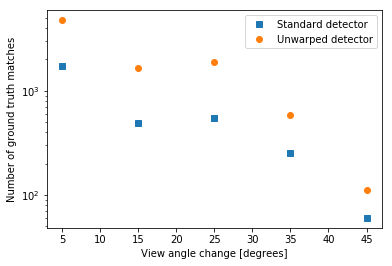

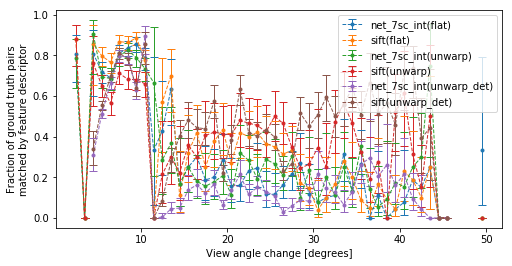

In [63]:
# Output plot

plot_acc_gt(acc)
plot_acc(acc)

# The uncertainties are of course very high in such a small sample